# Time-Series Analysis with Python
João Miguel
(joao.miguel@retail-consult.com)

Based in Notebook: [Intro to Time Series Forecasting](https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting) by Leonie

In this notebook, we will learn how to work with and predict time-series. Time-series are a collection of **time-dependent data** points. That means that each data point is assigned to a specific timestamp. Ideally, these data points are in chronological order and in constant time intervals (e.g. every minute or everyday). The time-series forecasting problem **analyzes patterns in the past data to make predictions about the future**. The most popular example is probably stock price prediction. Other examples are sales of seasonal clothing or weather forecasts. In contrast to regression problems, time-series are time-dependent and show specific characteristics, such as **trend and seasonality**.

**Overview**
* [Problem Definition](#Problem-Definition)<br>
* [Data Collection](#Data-Collection)<br>
* [Data Preprocessing](#Data-Preprocessing)<br>
    * [Chronological Order and Equidistant Timestamps](#[Chronological-Order-and-Equidistant-Timestamps])<br>
    * [Handling Missing Values](#Handling-Missing-Values)<br>
* [Feature Engineering](#Feature-Engineering)<br>
    * [Time Features](#Time-Features)<br>
    * [Decomposition](#Decomposition)<br>
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
    * [Autocorrelation Analysis](#Autocorrelation-Analysis)<br> 
* [Cross Validation](#Cross-Validation)<br>
* [Evaluation Metrics](#Evaluation-Metrics)<br>
* [Models](#Models)<br>
    * [Models for Univariate Time Series](#Models-for-Univariate-Time-Series)<br>
        * [Naive Approach](#Naive-Approach)<br>
        * [Moving Average](#Moving-Average)<br>
    * [Models for Multivariate Time Series](#Models-for-Multivariate-Time-Series)<br>
        * [Prophet](#Prophet)<br>
        * [DeepAR](#DeepAR)<br>

# Environment Setup

## Install Modules

In [1]:
!pip install numpy
!pip install pandas

!pip install seaborn
!pip install matplotlib

!pip install statsmodels
!pip install sklearn

!pip install mxnet

## Import Modules

In [1]:
# Libraries to manipulate data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Supress warnings 
import warnings
warnings.filterwarnings('ignore')

# Problem Definition
For this tutorial, we will build a model to predict the energy consumption of Tetouan City. 


<img src="https://www.travelatmorocco.com/wp-content/uploads/2019/11/tetouan_morocco.jpg" width="500" height="340">
<img src="https://www.africanworldheritagesites.org/assets/images/tetouan-map.jpg" width="500" height="340">

<!-- The question we want to answer is -->
> Question to answer: What is the future energy consumption of Zone 1 over the next 24 hours?

Energy consumption depends on human acticity and might depend on atmospheric condictions such as temperature, humidity, and wind speed.

# Data Collection
In a typical workflow for time series, this would be the time for data collection. In this example, we will skip the data collection step and use data from the [Power Consumption of Tetouan City Dataset](https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city). Therefore, this section will be a dataset overview. 

Although the dataset contains multiple columns that can be used as features, we will only be looking at the temperature, humidity, and wind speed ones, as well as the power consumption of Zone1. Time-series data usually comes in **tabular** format (e.g. csv files).

In [ ]:
# Read COLUMNS from dataframe
COLUMNS = ['DateTime', 'Temperature', 'Humidity', 'Wind Speed', 'Zone 1 Power Consumption']
df = pd.read_csv("data/Tetuan City power consumption.csv", usecols=COLUMNS)


# Indicate the target and feature columns
TARGET = 'Zone 1 Power Consumption'
FEATURES = [feature for feature in df.columns if feature not in [TARGET]]    # Feature columns to help predicting the target


# -------- T0 D0 --------
# Try to use the head method from the 
# df Dataframe to print its first rows
# -------- ----- --------

In [ ]:
# -------- T0 D0 --------
# Try to use the info method from the 
# df Dataframe to print information on its columns
# -------- ----- --------

Features:
* **Temperature** indicates the temperature of Tetouan city in degrees (°C) 
* **Humidity** indicates the weather humidity of Tetouan city (%)
* **Wind Speed** indicates the wind speed of Tetouan city (mph)

Target:
* **Zone 1 Power Consumption** indicates the power consumption in Zone 1 of Tetouan City (kW)


Since we are working with time-series, the most essential features are mainly time-related features. In this example, we have the column `DateTime` which  uniquely identifies each 10 minutes of a day. Ideally, the data is already in chronological order and the time stamps are equidistant in time series. This is already the case in our data: The time interval is 10 minutes and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.


> This column is provided in string format. Let's convert it to the `datetime64[ns]` data type.

In [ ]:
from datetime import datetime, date 

# Convert the DateTime columns from string type to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'], format = '%m/%d/%Y %H:%M')


# -------- T0 D0 --------
# Try to print the first rows of the
# df Dataframe using the method already used before
# -------- ----- --------

In [ ]:
# -------- T0 D0 --------
# Try to print the information on the
# df Dataframe columns using the method already used before
# -------- ----- --------

### Ploting Features and Target Time-Series

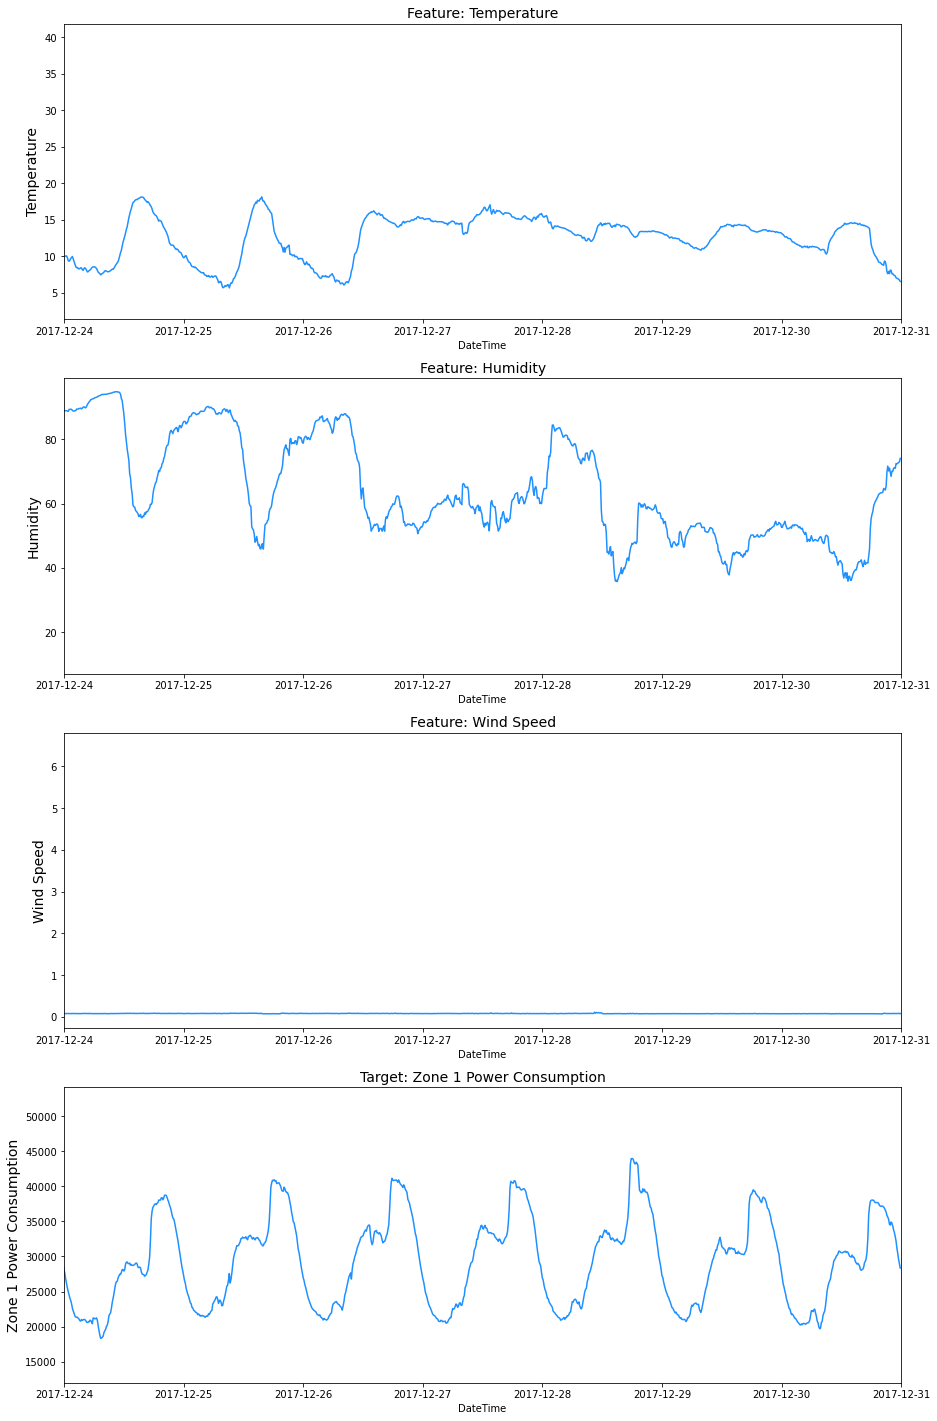

In [44]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))

sns.lineplot(x=df.DateTime, y=df.Temperature.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Temperature', fontsize=14)
ax[0].set_ylabel(ylabel='Temperature', fontsize=14)


sns.lineplot(x=df.DateTime, y=df.Humidity.fillna(np.inf), ax=ax[1], color='dodgerblue')
ax[1].set_title('Feature: Humidity', fontsize=14)
ax[1].set_ylabel(ylabel='Humidity', fontsize=14)


sns.lineplot(x=df.DateTime, y=df['Wind Speed'].fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Wind Speed', fontsize=14)
ax[2].set_ylabel(ylabel='Wind Speed', fontsize=14)


sns.lineplot(x=df.DateTime, y=df['Zone 1 Power Consumption'].fillna(np.inf), ax=ax[3], color='dodgerblue')
ax[3].set_title('Target: Zone 1 Power Consumption', fontsize=14)
ax[3].set_ylabel(ylabel='Zone 1 Power Consumption', fontsize=14)



# -------- T0 D0 --------
# 1. Run code to plot time-series from 01/Jan/2017 to 31/December/2021
# 2. Change START date and re-run the code to plot time-series from 1/June/2021 to 31/December/2021
# 4. Change START date and re-run the code to plot time-series from 20/November/2021 to 31/December/2021
# 5. Change START date and re-run the code to plot time-series from 24/December/2021 to 31/December/2021
# -------- ----- --------
START_YEAR, START_MONTH, START_DAY = 2017, 12, 24
END_YEAR, END_MONTH, END_DAY = 2017, 12, 31

START_DATE = date(START_YEAR, START_MONTH, START_DAY)
END_DATE = date(END_YEAR, END_MONTH, END_DAY)


for i in range(4):
    ax[i].set_xlim([START_DATE, END_DATE])


plt.show()

# Data Pre-processing

## Chronological Order and Equidistant Timestamps
The data should be in **chronological order** and the **timestamps should be equidistant** in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidistant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data (see [Resampling](#Resampling)).

This is already the case in our data: The time interval is 10 minutes and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step. 

In [64]:
# Sort dataframe rows by timestamp
df = df.sort_values(by='DateTime')

# Calculate time intervals
df['Time_Interval'] = df.DateTime - df.DateTime.shift(1)


# -------- T0 D0 --------
# Print DateTime and Time_Interval values
# for the first rows of df
# -------- ----- --------

The method value_counts can be used in a Series (or selected column from a DataFrame) to check how many times the different values of the column are repeated. In this case, we can use this method in the 'Time_Interval' column of df to check if there is only one interval repeated across this column.

In [65]:
# -------- T0 D0 --------
# Try to select the Time_Interval column from df and
# call the value_counts method to see the different values of this column
# -------- ----- --------
df['Time_Interval'].value_counts()

0 days 00:10:00    52415
Name: Time_Interval, dtype: int64

The method value_counts can be used in a Series (or selected column from a DataFrame) to check how many times the different values of the column are repeated. In this case, we can use this method in the 'Time_Interval' column of df to check if there is only one interval repeated across this column.

In [ ]:
# -------- T0 D0 --------
# Try to use the drop method to remove the Time_Interval
# column from the df Dataframe. Use the head method to
# check if the drop was sucesseful by checking the first rows
# -------- ----- --------
df = (...) # USE DROP
df.head()

## Handling Missing Values

We can see that `Humidity` has missing values. We will have to clean them by replacing them by filling them.

In [33]:
df.isna().sum()

DateTime                    0
Temperature                 0
Humidity                    2
Wind Speed                  0
Zone 1 Power Consumption    0
dtype: int64

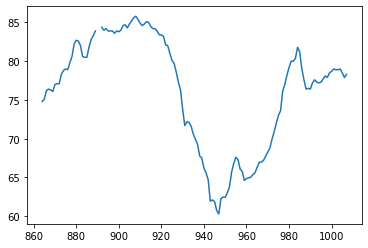

In [33]:
cond = df['DateTime'].dt.date == date(2017, 1, 7)
plt.plot(df[cond]['Humidity'])

Now we have to think about what to do with these missing values. 

* **Option 1: Fill NaN with Mean Value**

    In this example, we can fill NaNs with the mean values considering the neighbours timestamps before/preceding and after/following the missing values.

* **Option 2: Fill NaN with Last Value with `.ffill()`**

    Filling NaNs with the last/following value is also an option.


In [29]:
# Calculate the mean value of humidity:

# 1. considering all time-points
humidity_mean = df['Humidity'].mean()

# 2. considering closest time-points to the gap
closest = df['DateTime'].dt.date == date(2017, 1, 7)
closest &= (df['DateTime'].dt.hour == 4) & df['DateTime'].dt.minute.isin([10, 40])
humidity_mean_2 = df[closest]['Humidity'].mean()

print (f'Humidity (mean): {humidity_mean}\nHumidity (mean of closest points): {humidity_mean_2}')

Humidity (mean): 68.25889304384366
Humidity (mean of closest points): 84.15


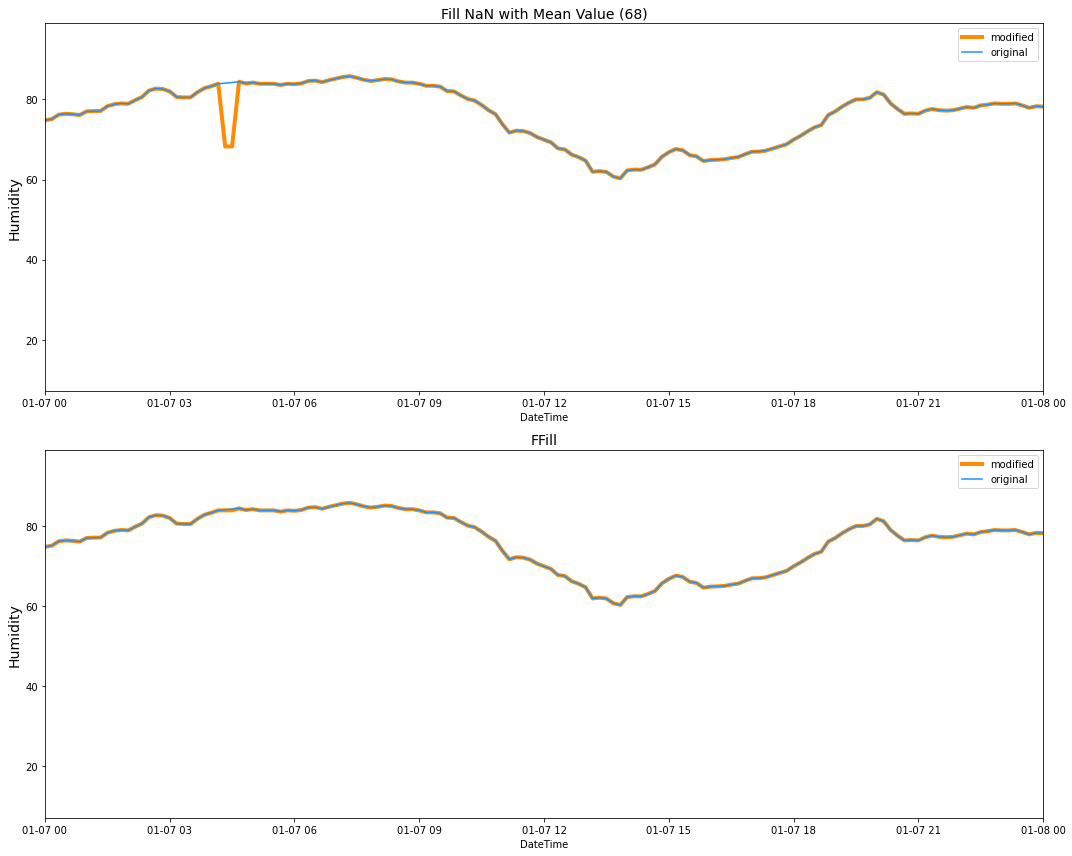

In [32]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))


# -------- T0 D0 --------
# 1. Try to run the code using the humidity_mean value as the choosen mean
# The orange line shows the new time-series obtained after filling the null gap with the chosen mean.
# 2. Now try to run the code using the humidity_mean_2 as the choosen mean
# -------- ----- --------
CHOOSE_MEAN = humidity_mean


sns.lineplot(x=df['DateTime'], y=df['Humidity'].fillna(CHOOSE_MEAN), ax=ax[0], color='darkorange', label = 'modified', lw=4)
sns.lineplot(x=df['DateTime'], y=df['Humidity'], ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title(f'Fill NaN with Mean Value ({CHOOSE_MEAN:.0f})', fontsize=14)
ax[0].set_ylabel(ylabel='Humidity', fontsize=14)


sns.lineplot(x=df['DateTime'], y=df['Humidity'].ffill(), ax=ax[1], color='darkorange', label = 'modified', lw=4)
sns.lineplot(x=df['DateTime'], y=df['Humidity'], ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'FFill', fontsize=14)
ax[1].set_ylabel(ylabel='Humidity', fontsize=14)


for i in range(2):
    ax[i].set_xlim([date(2017, 1, 7), date(2017, 1, 8)])
plt.tight_layout()
plt.show()

In [36]:
df['Humidity'] = df['Humidity'].fillna(humidity_mean_2)

# -------- T0 D0 --------
# Try to check if there still existing null values in the
# Humidity column using the same method used above
# -------- ----- --------

# Feature Engineering

## Time Features

In [73]:
df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['day'] = df['DateTime'].dt.day
df['weekday'] = df['DateTime'].dt.weekday
df['day_of_year'] = df['DateTime'].dt.dayofyear
df['week_of_year'] = df['DateTime'].dt.weekofyear
df['quarter'] = df['DateTime'].dt.quarter
df['season'] = df.month%12 // 3 + 1


TIME_FEATURES = ['DateTime', 'year', 'month', 'day', 'weekday', 'day_of_year', 'week_of_year', 'quarter', 'season']
df[TIME_FEATURES].head()

,DateTime,year,month,day,weekday,day_of_year,week_of_year,quarter,season
0,2017-01-01 00:00:00,2017,1,1,6,1,52,1,1
1,2017-01-01 00:10:00,2017,1,1,6,1,52,1,1
2,2017-01-01 00:20:00,2017,1,1,6,1,52,1,1
3,2017-01-01 00:30:00,2017,1,1,6,1,52,1,1
4,2017-01-01 00:40:00,2017,1,1,6,1,52,1,1


## Decomposition

The **characteristics of a time series** are
* Trend and Level
* Seasonality
* Random / Noise

We can use the function `seasonal_decompose()` from the [statsmodels](https://www.statsmodels.org) library.

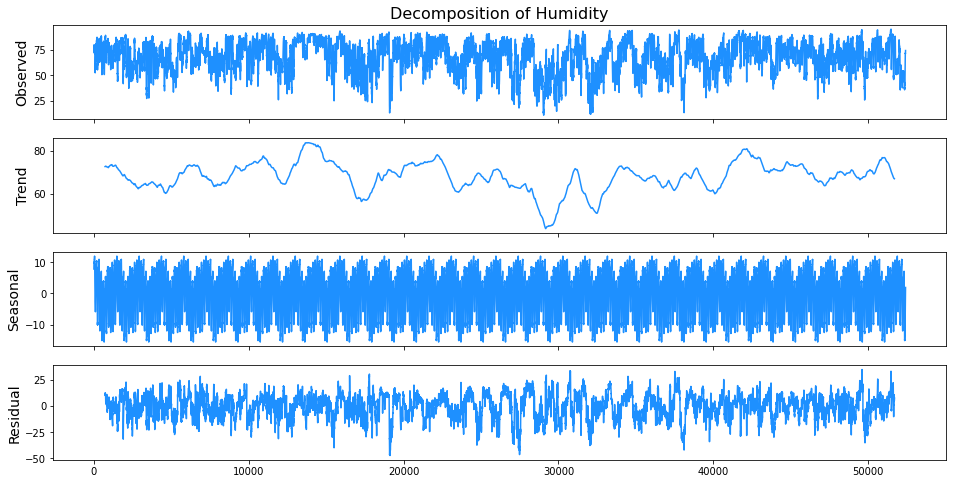

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(df['Humidity'], period=1440, model='additive')

ax[0].set_title('Decomposition of Humidity', fontsize=16)
res = seasonal_decompose(df.Humidity, period=1440, model='additive')

res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

plt.show()

# Exploratory Data Analysis

Exploratory analysis is essential to better understand the data, providing visual guidance on the variables and their relationship with the target to be predicted. It also allows us to detect trends and patterns in the target variable. 

In a general way, a careful and extensive analysis allows us to make some important decisions, for example:
- which forecasting models better fit our data
- which variables can be used as features, as well as feature engineering steps we can make to create new features from the existing ones. The inclusion of such features must increase the predictive power of the
- the sizes of context and prediction windows.

To do so, we can create graphs for:
- Analyze **discrete variables** and their relationship with the target variable: Barplots, Boxplots, etc.
- Analyze **continuous variables** and their relationship with the target variable: Scatterplots, Matrix of Correlation, etc.
- Analyze **trends and patterns** in the target variable and in the features: Lineplots, etc.

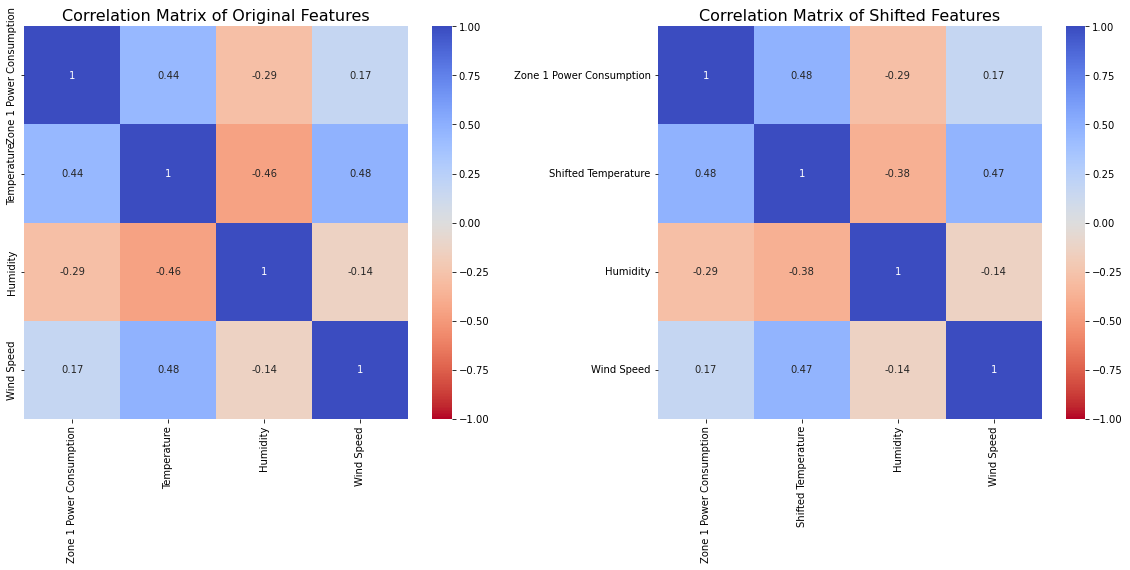

In [72]:
SHIFT_PERIODS = 15
df['Shifted Temperature'] = df['Temperature'].shift(SHIFT_PERIODS)


f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

original_cols = [TARGET] + FEATURES
corrmat = df[original_cols].corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Original Features', fontsize=16)


shifted_cols = [TARGET] + ['Shifted Temperature', 'Humidity', 'Wind Speed']
corrmat = df[shifted_cols].corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Shifted Features', fontsize=16)

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='month', ylabel='Zone 1 Power Consumption'>

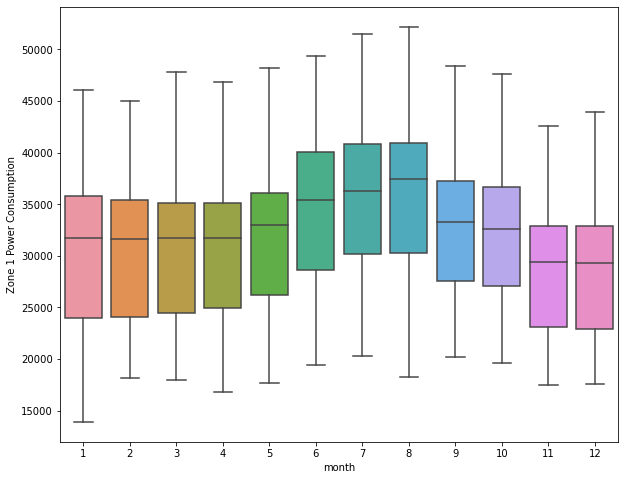

In [79]:
# -------- T0 D0 --------
# 1. Run the code usint the month feature in the x axis
# 2. Now change the x axis to the weekday feature
# 3. Try to plot using different discrete features as the x axis
# -------- ----- --------
X_FEATURE = "month"

fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)

sns.boxplot(x=X_FEATURE, y=TARGET, data=df, ax=ax)

## Autocorrelation Analysis


This EDA step is especially important when using [ARIMA](#ARIMA), as well as to determine the forecasting window.

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

* **Autocorrelation  Function (ACF)**: Correlation between time series with a lagged version of itself. The autocorrelation function starts a lag 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.
* **Partial Autocorrelation Function (PACF)**: Additional correlation explained by each successive lagged term.

As we can infer from the graph above, the autocorrelation continues to decrease as the lag increases, confirming that there is no linear association between observations separated by larger lags.

For the AR process, we expect that the ACF plot will gradually decrease and simultaneously the PACF should have a sharp drop after p significant lags. To define a MA process, we expect the opposite from the ACF and PACF plots, meaning that: the ACF should show a sharp drop after a certain q number of lags while PACF should show a geometric or gradual decreasing trend.

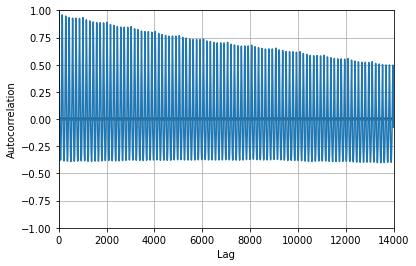

In [74]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Zone 1 Power Consumption']).set_xlim([0, 14000])
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df[TARGET],lags=7000, ax=ax[0])
plot_pacf(df[TARGET],lags=7000, ax=ax[1])
plt.show()

# Cross Validation

For cross validation, you can use the [Time Series Split](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split) library.

<img src="https://miro.medium.com/max/1400/1*eDhIeekv2HkUHTiWUZ_dcg.png" width="750">



In [67]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 5
FIRST_DAY = date(2017, 12, 24) # year, month, day - 24/December/2021

select_days = df['DateTime'].dt.date >= FIRST_DAY

df1 = df[select_days].reset_index()
X = df1.DateTime
y = df1[TARGET]

folds = TimeSeriesSplit(n_splits=N_SPLITS)

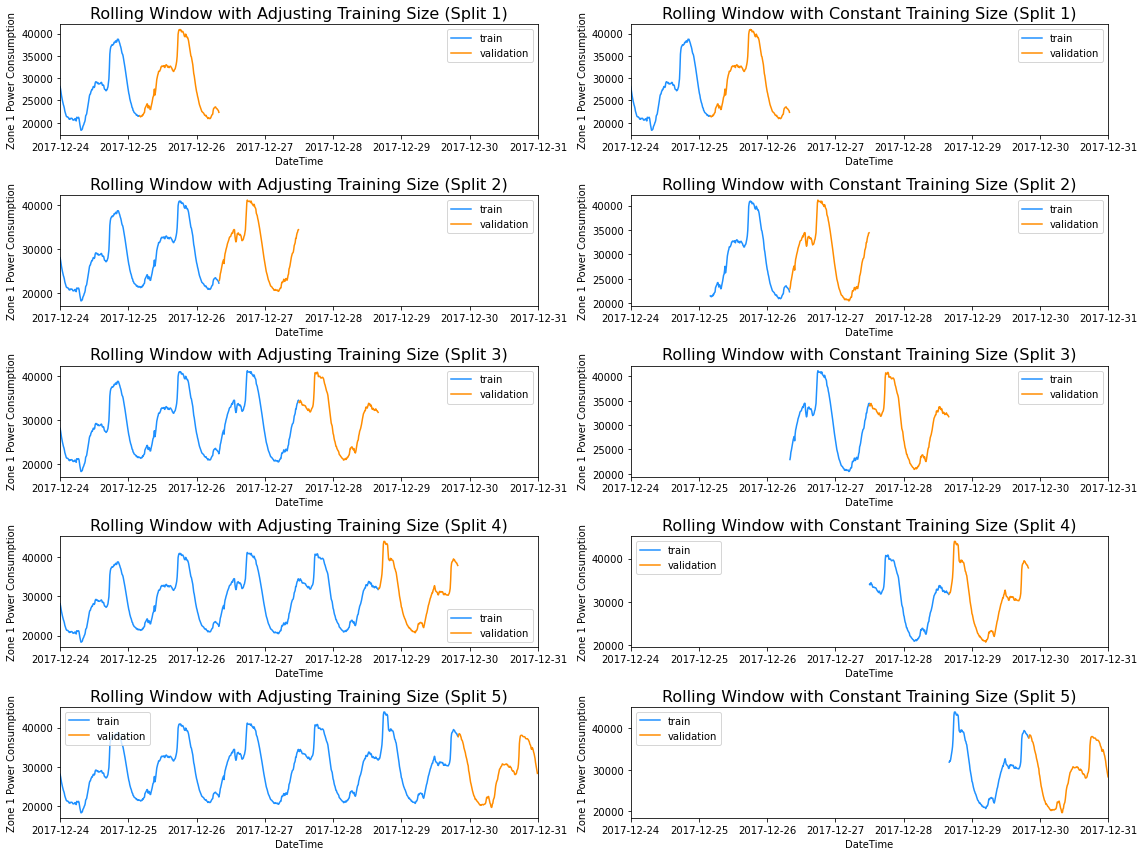

In [68]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 12))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2017, 12, 24), date(2017, 12, 31)])
    ax[i, 1].set_xlim([date(2017, 12, 24), date(2017, 12, 31)])

plt.tight_layout()
plt.show()

# Evaluation Metrics
Time-series are allways divided into training and test sets. The training data is used to train the models, and the fitted model is used to predict the values of the test interval. The predicted values are compared to the actual values of test data using evaluation metrics. These metrics can range from simpler calculations, such as the average of absolute differences between forecasts and actual values, to more complex calculations. 

> Different evaluation metrics have different **advantages and disadvantages**, so their applicability depends on the context of the forecasting problem and the data we intend to work on. As such, **these should be selected carefully**, depending on this selection from a prior analysis.

Below, we make a short listing and description of some of the most common and well-known metrics in the time-series forecasting area.

### Scale-Dependent Mearures
These measures depend on the scale of the data. They are generally based on the mean and median values of the absolute errors between forecasts and the actual values of the time-series. It has the advantage of its easy interpretation and their calculation is quite simple. However, when we want to compare the performance of a model in different time series, with different magnitudes of values, these measures are not adequate as they don't make a fair comparison.

**Examples:** Mean Absolute Error (MAE), Root Mean Squared Error (RMSE)

### Measures based on percentage errors
These measures are based on percentage errors between forecasts and the current values of the time-series. As such, they are independent of the scale of the time-series and, therefore, can be used in the evaluation of a model in different time series. As a disadvantage, these measures cannot be used to evaluate forecasts in time series that have present the value zero at least once.

**Examples:** Mean Absolute Percentage Error (MAPE)

### Scaled Measures
These scaled measures were proposed to overcome the disadvantages of the errors described above, being one of the best known the MASE metric. The measures are obtained by scaling the error on the in-sample MAE value obtained using a naive forecast method. Although they are more difficult to calculate than the above metrics, they are the most recommended in many scenarios of more complex forecasting problems.

**Examples:** Mean Absolute Scaled Error (MASE)

# Models

Time-series can be either **univariate or multivariate**:
* **Univariate** time-series only has a single time-dependent variable.
* **Multivariate** time-series have multiple time-dependent variables.

Our example originally is a multivariate time-series as it has multiple features that are time-dependent. However, by only looking at the target variable `Zone 1 Power Consumption` we can convert it to a univariate time-series.

We will focus on a **quarterly forecast**. We will use the **Q2 2020 as test data** and the remaining data will be **split by quarter for cross validation**.

We will evaluate the Mean Absolute Error (MAE) and the Root Mean Square Error (RMSE) of the models.

## Models for Univariate Time-Series

* Examples
    * [Naive Approach](#Naive-Approach)<br>
    * [Moving Average](#Moving-Average)<br>
    * [Exponential Smoothing](#MExponential-Smoothing)<br>
    * [ARIMA](#ARIMA)<br>
    * [Prophet](#Prophet) (However, it can also be used with exogeneous variables)<br>

In [70]:
df1['date'] = df1['DateTime'].dt.date
df1['day_idx'] = (df1.date != df1.date.shift(1)).cumsum()

N_SPLITS = 7

X = df1[df1.day_idx < N_SPLITS][FEATURES]
y = df1[df1.day_idx < N_SPLITS][TARGET]

X_test = df1[df1.day_idx == N_SPLITS][FEATURES].reset_index(drop=True)
y_test = df1[df1.day_idx == N_SPLITS][TARGET].reset_index(drop=True)

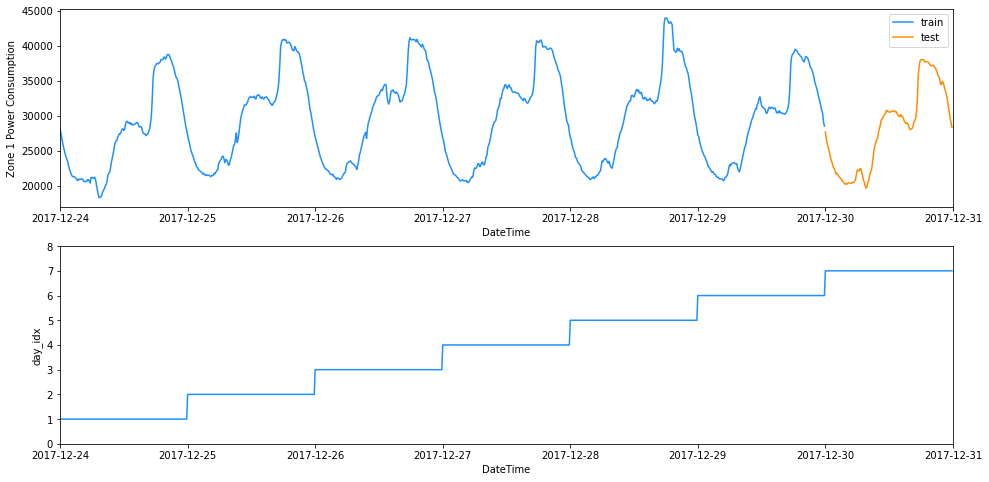

In [71]:
folds = np.linspace(0, N_SPLITS-3, num=N_SPLITS-2)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

sns.lineplot(x=X.DateTime, y=y, ax=ax[0], color='dodgerblue', label='train')
sns.lineplot(x=X_test.DateTime, y=y_test, ax=ax[0], color='darkorange', label='test')

sns.lineplot(x=df1.DateTime, y=df1.day_idx, ax=ax[1], color='dodgerblue')
ax[0].set_xlim([date(2017, 12, 24), date(2017, 12, 31)])
ax[1].set_xlim([date(2017, 12, 24), date(2017, 12, 31)])
ax[1].set_ylim([0, N_SPLITS+1])

plt.show()

In [74]:
def plot_approach_evaluation(y_pred, score_mae, score_rsme, approach_name):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    f.suptitle(approach_name, fontsize=16)
    sns.lineplot(x=X.DateTime, y=y, ax=ax[0], color='dodgerblue', label='Training', linewidth=2)
    sns.lineplot(x=X_test.DateTime, y=y_test, ax=ax[0], color='gold', label='Ground Truth', linewidth=2) #navajowhite
    sns.lineplot(x=X_test.DateTime, y=y_pred, ax=ax[0], color='darkorange', label='Predicted', linewidth=2)
    ax[0].set_xlim([date(2017, 12, 24), date(2017, 12, 31)])
    ax[0].set_title(f'Prediction \n MAE: {mean_absolute_error(y_test, y_pred):.2f}, RSME: {math.sqrt(mean_squared_error(y_valid, y_valid_pred)):.2f}', fontsize=14)
    ax[0].set_xlabel(xlabel='DateTime', fontsize=14)
    ax[0].set_ylabel(ylabel='Zone 1 Power Consumption', fontsize=14)

    sns.lineplot(x=folds, y=score_mae,  color='gold', label='MAE', ax=ax[1])#marker='o',
    sns.lineplot(x=folds, y=score_rsme, color='indianred', label='RSME', ax=ax[1])
    ax[1].set_title('Loss', fontsize=14)
    ax[1].set_xlabel(xlabel='Fold', fontsize=14)
    ax[1].set_ylabel(ylabel='Loss', fontsize=14)
     
    plt.show()

### Naive Approach

$\hat y_{t+1} = y_t$

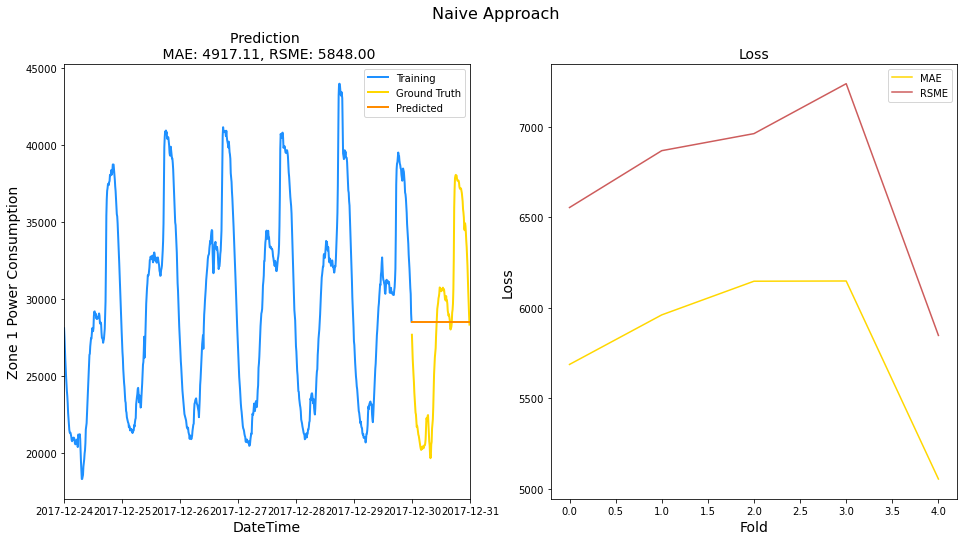

In [78]:
score_mae = []
score_rsme = []

for fold, valid_day_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df1[df1.day_idx < valid_day_id].index
    valid_index = df1[df1.day_idx == valid_day_id].index

    # Prepare training and validation data for this fold
    #X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Initialize y_valid_pred
    y_valid_pred = pd.Series(np.ones(len(y_valid)))
    
    # Prediction: Naive approach
    y_valid_pred = y_valid_pred * y_train.iloc[-1]
    
    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.ones(len(X_test))) * y.iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Naive Approach')

### Moving Average

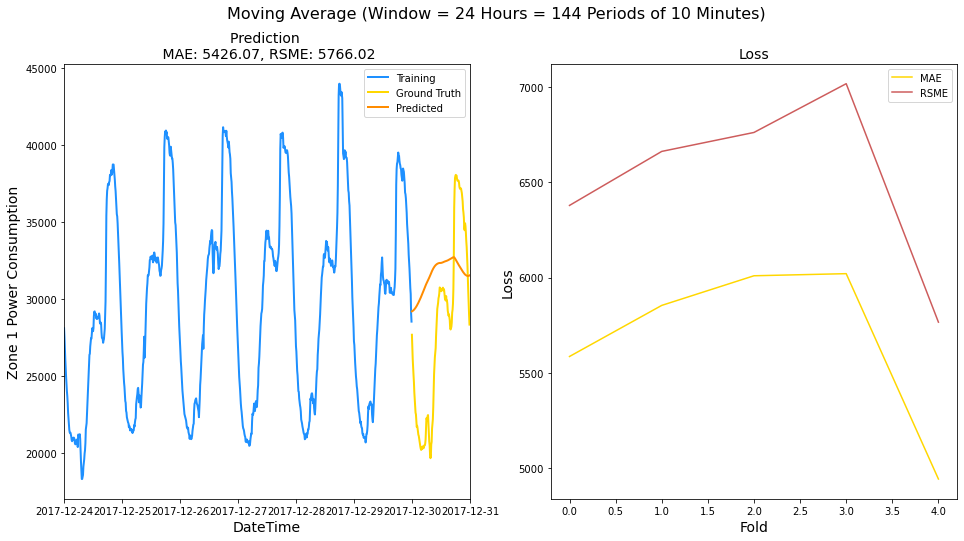

In [79]:
score_mae = []
score_rsme = []

for fold, valid_day_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df1[df1.day_idx < valid_day_id].index
    valid_index = df1[df1.day_idx == valid_day_id].index

    # Prepare training and validation data for this fold
    # X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Initialize y_valid_pred
    y_valid_pred = pd.Series(np.ones(len(y_valid)))
    
    # Prediction: Naive approach    
    for i in range(len(y_valid_pred)):
        y_valid_pred.iloc[i] = y_train.append(y_valid_pred.iloc[:(i)]).reset_index(drop=True).rolling(4).mean().iloc[-1]
        
    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.zeros(len(X_test)))

# 144
for i in range(len(y_pred)):
    y_pred.iloc[i] = y.append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(144).mean().iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Moving Average (Window = 24 Hours = 144 Periods of 10 Minutes)')

Neither the Naive Approach nor the Moving Average Approach are yielding good results for our example. Usually, these approaches serve as a **benchmark** rather than the method of choice.

## Models for Multivariate Time Series

### Prophet

The Prophet library implements a forecasting method capable of accurately capturing the patterns and behaviors of a time series using only its history in the past. In our case, our time-series to be predicted has strong daily seasonality (repetitive behavior), so the past values ​are enough for the Prophet model to predict the future ones. However, these models also have the ability to include other time-dependent variables as exogenous features/variables, as can be seen in the Prophet documentation ([Additional Regressors](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors)).

In [94]:
from prophet import Prophet

m = Prophet(changepoint_prior_scale=0.01)

df1['ds'] = df1['DateTime']
df1['y'] = df1[TARGET]

is_train = df1['DateTime'].dt.date < date(2017, 12, 30)
m.fit(df1[is_train][['ds', 'y']])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


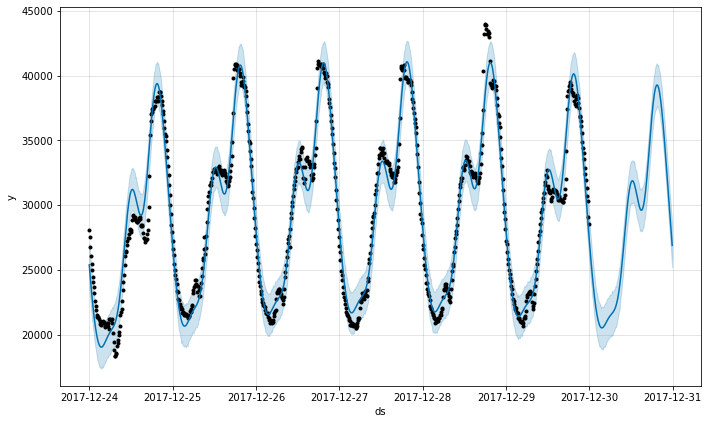

In [98]:
NUM_DAYS = 1
PERIODS = NUM_DAYS * 24 * 6

future = m.make_future_dataframe(periods=PERIODS, freq='10min')
fcst = m.predict(future)
fig = m.plot(fcst)

### DeepAR: Probabilistic Forecasting

In [91]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.distribution.poisson import PoissonOutput
from gluonts.evaluation.backtest import make_evaluation_predictions, Evaluator
from gluonts.model.predictor import Predictor

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

In [88]:
# Reused method from Gluonts documentation

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [90]:
is_train = df1['DateTime'].dt.date < date(2017, 12, 30)

train_ds = ListDataset(
    [
        {
            FieldName.TARGET: df1[is_train][TARGET],
            FieldName.START: df1['DateTime'].min(),
            FieldName.FEAT_DYNAMIC_REAL: [
                df1[is_train][f] for f in FEATURES
            ]
        }
    ],
    freq='10min'
)

test_ds = ListDataset(
    [
        {
            FieldName.TARGET: df1[TARGET_COL],
            FieldName.START: df1['DateTime'].min(),
            FieldName.FEAT_DYNAMIC_REAL: [
                df1[f] for f in FEATURE_COLS
            ]
        }
    ],
    freq='10min'
)

In [92]:
trainer = Trainer(epochs=10)
estimator = DeepAREstimator(
    freq="10min", 
    prediction_length=144, 
    trainer=trainer,
    use_feat_dynamic_real = False
)

predictor = estimator.train(train_ds)

100%|████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s, epoch=10/10, avg_epoch_loss=7.67]


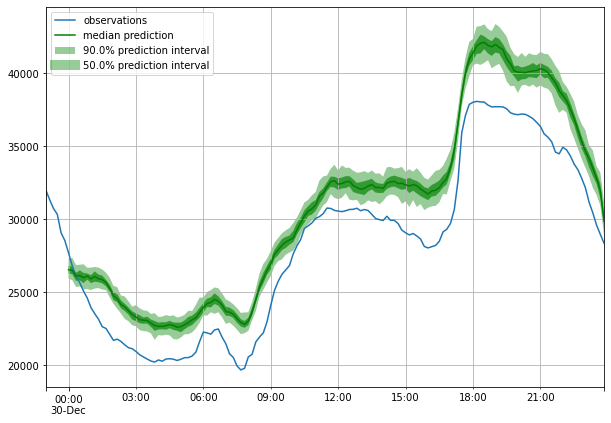

In [93]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

plot_prob_forecasts(tss[0], forecasts[0])

# Additional Ressources

## My Time Series Forecasting Series

* [Intro to Time Series Forecasting](https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting)
* [Time Series Forecasting: Building Intuition](https://www.kaggle.com/iamleonie/time-series-forecasting-building-intuition)
* [Time Series Forecasting: Interpreting ACF and PACF](https://www.kaggle.com/iamleonie/time-series-interpreting-acf-and-pacf)
* [Time Series Forecasting: Tips & Tricks for Training LSTMs](https://www.kaggle.com/iamleonie/time-series-tips-tricks-for-training-lstms)

## Other Ressources
Here are some additional ressources that helped me learn about time series
* [Getting started with Time Series using Pandas ](https://www.kaggle.com/parulpandey/getting-started-with-time-series-using-pandas)
* [Time Series Analysis || An Introductory Start](https://www.kaggle.com/janiobachmann/time-series-analysis-an-introductory-start)
* [Everything you can do with a time series](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series)
* [Deep Learning for Time Series | Dimitry Larko | Kaggle Days](https://www.youtube.com/watch?v=svNwWSgz2NM)
* [Encoding Cyclical Features for Deep Learning](https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning)
* [Tamara Louie: Applying Statistical Modeling & Machine Learning to Perform Time-Series Forecasting](https://www.youtube.com/watch?v=JntA9XaTebs)
* [Forecasting: Principles and Practice](https://otexts.com/fpp2/)
* [Easy Guide on Time Series Forecasting](https://beingdatum.com/time-series-forecasting/)
* [Installing FBProphet/Prophet for Time Series Forecasting in Jupyter Notebook](https://medium.com/data-folks-indonesia/installing-fbprophet-prophet-for-time-series-forecasting-in-jupyter-notebook-7de6db09f93e)

# Useful Libraries
* [statsmodels](https://www.statsmodels.org)
* [Pandas Time series / date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
* [Time Series Split](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split)
* [Prophet](https://facebook.github.io/prophet/docs/quick_start.html)
* [Gluonts](https://ts.gluon.ai/)

In [1]:
!conda activate time_series

In [4]:
!conda env list

# conda environments:
#
base                  *  C:\Users\joao.miguel\Anaconda3
time_series              C:\Users\joao.miguel\Anaconda3\envs\time_series



In [6]:
!conda activate time_series

In [ ]:
!conda install scipy==1.6.2